# Last Layer Clue
In this notebook, we'll test the new, simplified CLUE implementation. We're using Bayesian last layers for uncertainty estimation.

## Setup


Import libraries

In [1]:
import importlib
import models.regene_models as regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import clue.new_CLUE as new_CLUE
importlib.reload(new_CLUE)
import models.BLL
import models.mnist_classifier_BLL
import models.BLL_VI
import models.regene_models 


Set the configuration

In [2]:
# 1. Configuration
class Config:
    # Data
    train = False    # Evaluate on validation set every epoch
    latent_dim = 256
    
    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'
    
cfg = Config()

Load the Datasets

In [3]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Create a models directory if it doesn't exist

In [4]:
# Create models directory if it doesn't exist
os.makedirs('../model_saves', exist_ok=True)
model_saves_dir = '../model_saves'

## Prepare the Backbone and Decoder
We'll be testing the CLUE implementation on the BLL model. We first need load (or train) the decoder.

### Load the models

We load the backbone classifier

In [5]:
importlib.reload(models.mnist_classifier_BLL)  # Reload the module
from models.mnist_classifier_BLL import MNISTClassifierBLL  # Import the class

backbone = MNISTClassifierBLL(device=cfg.device)
print(f"Backbone will run on: {cfg.device}")

Backbone will run on: mps


Load weights

In [6]:
backbone.load_weights(model_saves_dir + '/mnist_backbone_models/backbone_best_12_epochs.pt')

 [load_weights] Loaded backbone weights from ../model_saves/mnist_backbone_models/backbone_best_12_epochs.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/mnist_classifier_BLL.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

Next, define the decoder

In [7]:
decoder = regene_models.Decoder(latent_dim=cfg.latent_dim, device=cfg.device)

Train it if you want

In [8]:
if cfg.train:
    decoder.train_decoder(trainloader, backbone, num_epochs=12, lr=0.001)
    torch.save(decoder.state_dict(), os.path.join(model_saves_dir, 'decoder_BLL.pth'))

...or load it

In [9]:
decoder.load_state_dict(torch.load(os.path.join(model_saves_dir, 'decoder_BLL.pth')))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_32613/3334151885.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(os.path.jo

<All keys matched successfully>

### Try Joint Training Backbone and Decoder

Define the models

In [10]:
importlib.reload(regene_models)

joint_decoder = regene_models.Decoder(latent_dim=256, device=cfg.device)
joint_backbone = regene_models.Classifier(latent_dim=cfg.latent_dim, num_classes=10, device=cfg.device)

And load

In [11]:
joint_backbone.load_state_dict(torch.load(os.path.join(model_saves_dir, 'joint_classifier.pth'), map_location=cfg.device))
joint_decoder.load_state_dict(torch.load(os.path.join(model_saves_dir, 'joint_decoder.pth'), map_location=cfg.device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_32613/37459159.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  joint_backbone.load_state_dict(torch.load(os.pa

<All keys matched successfully>

## Load the BLL classifier

Define the MCMC model

In [12]:
from models.BLL import BayesianLastLayerCat
importlib.reload(models.BLL)

bll = BayesianLastLayerCat(
    backbone=backbone,
    input_dim=256,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    N_train=len(trainset),
    lr=0.001,
    base_C=1.0,
    gauss_sig=0.01,
    device=cfg.device
)

Load the MCMC model

In [13]:
bll.load_checkpoint(model_saves_dir + '/mnist_bll_models/BLL_checkpoint_100_epochs.pth')

 [load_checkpoint] Loaded checkpoint from ../model_saves/mnist_bll_models/BLL_checkpoint_100_epochs.pth


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/BLL.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torc

Define the VI model

In [14]:
from models.BLL_VI import BayesianLastLayerVI
importlib.reload(models.BLL_VI)

bll_vi = BayesianLastLayerVI(
    backbone=backbone,
    input_dim=256,
    output_dim=10,
    device=cfg.device  
)

Load the VI model

In [15]:
bll_vi.load_checkpoint(model_saves_dir + '/mnist_bll_vi_models/BLL_VI_Base.pt')

 [load_checkpoint] Loaded checkpoint from ../model_saves/mnist_bll_vi_models/BLL_VI_Base.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/BLL_VI.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

Or, if using joint training

In [16]:
from models.BLL_VI import BayesianLastLayerVI
importlib.reload(models.BLL_VI)

bll_vi_joint = BayesianLastLayerVI(
    backbone=joint_backbone,
    input_dim=256,
    output_dim=10,
    device=cfg.device  
)

In [17]:
bll_vi_joint.load_checkpoint(model_saves_dir + '/mnist_bll_vi_models/BLL_VI_Joint_Decoder.pt')

 [load_checkpoint] Loaded checkpoint from ../model_saves/mnist_bll_vi_models/BLL_VI_Joint_Decoder.pt


## Get uncertain images

Get the most uncertain images, we need a non-shuffled loader for this.

In [48]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all test set data points
uncertainties = []
indices = []

bll.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(cfg.device)
        # Get predictions and uncertainties using BLL model
        _, uncertainty_dict = bll.predict_with_uncertainty(images)
        
        # Store total uncertainties and indices
        uncertainties.extend(uncertainty_dict['total_entropy'].cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(testset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties = uncertainties[sorted_idx]
sorted_data_indices = indices[sorted_idx]

We then plot the plot the most uncertain predictions on the test set.

In [49]:
import matplotlib.pyplot as plt
import torch

def plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=5):
    """
    Plots the top-n most uncertain predictions from the training set.

    Args:
        testset (torch.utils.data.Dataset): Dataset that returns (image, label) samples.
        sorted_data_indices (np.ndarray): Array of indices sorted in descending order by uncertainty.
        sorted_uncertainties (np.ndarray): Array of uncertainty (entropy) values, sorted to match sorted_data_indices.
        n_plot (int): Number of images to plot.
    """
    # Calculate number of rows needed
    images_per_row = 10
    n_rows = (n_plot - 1) // images_per_row + 1
    
    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_plot):
        data_idx = sorted_data_indices[i]
        image, _ = testset[data_idx]
        
        # If image is a torch.Tensor, convert it to a NumPy array.
        if torch.is_tensor(image):
            image = image.cpu().detach().numpy()
            # If the image has one channel [1, H, W], squeeze out the channel dimension.
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
        
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Entropy: {sorted_uncertainties[i]:.2f}")
        plt.axis("off")
    
    plt.suptitle("Most Uncertain Predictions")
    plt.show()

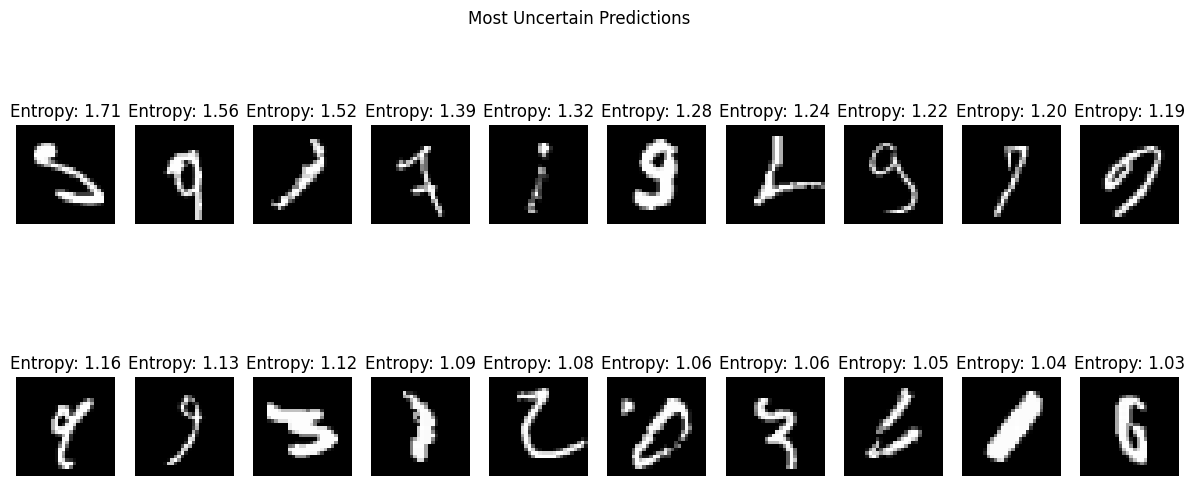

In [50]:
# Plot the most uncertain predictions
plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=20)

## Test new CLUE implementation

Now we test the "new" CLUE implementation, which accepts only a classifier head, directly optimising the latent code. There is no need for a decoder at each step (and therefore inside the CLUE method). 
Once the latent code is optimised, we pass it through the decoder to get a reconstruction from this notebook.

### Visualising

The first test is just with one image

Step 00: Loss: 1.2233, Total Entropy: 1.2233, Epistemic Entropy: 0.0062, Aleatoric Entropy: 1.2171, Distance: 0.0000
Step 01: Loss: 1.1953, Total Entropy: 1.1873, Epistemic Entropy: 0.0059, Aleatoric Entropy: 1.1814, Distance: 0.1600
Step 02: Loss: 1.1551, Total Entropy: 1.1404, Epistemic Entropy: 0.0057, Aleatoric Entropy: 1.1347, Distance: 0.2950
Step 03: Loss: 1.1031, Total Entropy: 1.0815, Epistemic Entropy: 0.0053, Aleatoric Entropy: 1.0762, Distance: 0.4324
Step 04: Loss: 1.0398, Total Entropy: 1.0112, Epistemic Entropy: 0.0049, Aleatoric Entropy: 1.0064, Distance: 0.5707
Step 05: Loss: 0.9671, Total Entropy: 0.9315, Epistemic Entropy: 0.0044, Aleatoric Entropy: 0.9271, Distance: 0.7105
Step 06: Loss: 0.8877, Total Entropy: 0.8451, Epistemic Entropy: 0.0039, Aleatoric Entropy: 0.8412, Distance: 0.8520
Step 07: Loss: 0.8048, Total Entropy: 0.7551, Epistemic Entropy: 0.0034, Aleatoric Entropy: 0.7517, Distance: 0.9952
Step 08: Loss: 0.7220, Total Entropy: 0.6650, Epistemic Entropy:

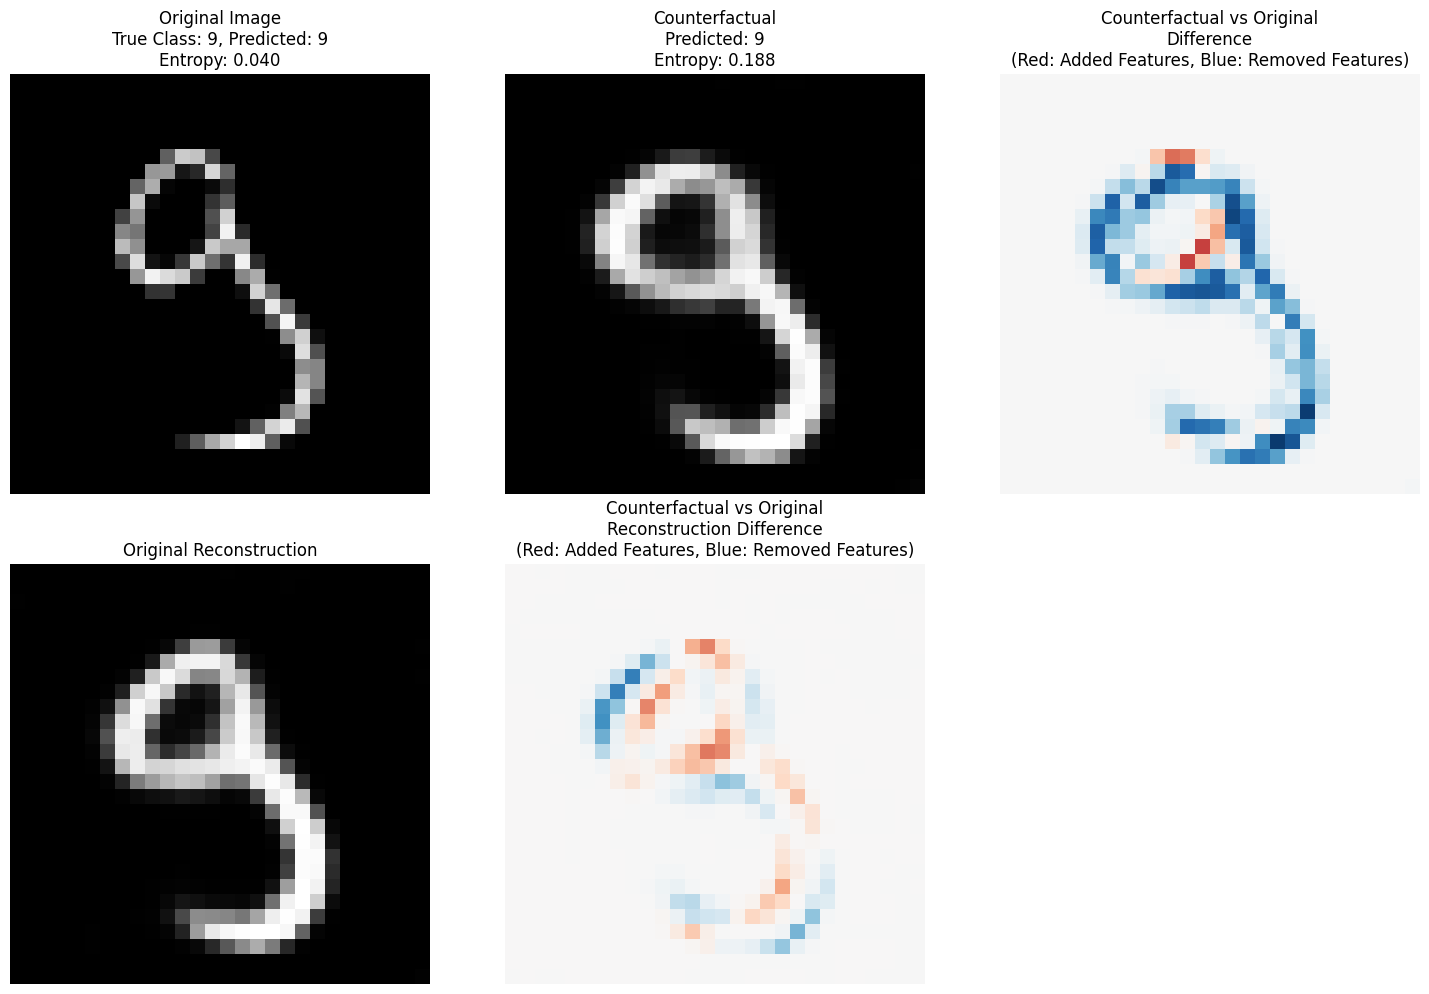

In [51]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[7]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
bll.eval()
with torch.no_grad():
    z0 = bll.extract_features(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=bll,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.05,
    lr=0.01,
    device=cfg.device,
    bayesian=True,
    verbose=True
)

# Optimize to find explanation
z_explained = clue.optimize(steps=100)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = decoder(z0)
    # CLUE reconstruction  
    clue_recon = decoder(z_explained)
    
    # Get predictions and uncertainties from latent codes
    original_probs_latent = bll.sample_predict_z(z0)  # [n_ensemble, batch, classes]
    explained_probs_latent = bll.sample_predict_z(z_explained)
    
    # Get predictions from full classifier workflow on reconstructions
    original_probs_recon = bll.sample_predict(original_recon)
    explained_probs_recon = bll.sample_predict(clue_recon)
    
    # Calculate mean probabilities and entropies for latent predictions
    original_mean_probs_latent = original_probs_latent.mean(dim=0)  # [batch, classes]
    explained_mean_probs_latent = explained_probs_latent.mean(dim=0)
    
    original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
    explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)
    
    # Calculate mean probabilities and entropies for reconstruction predictions
    original_mean_probs_recon = original_probs_recon.mean(dim=0)
    explained_mean_probs_recon = explained_probs_recon.mean(dim=0)
    
    original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
    explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)
    
    # Get predicted classes
    original_pred = original_mean_probs_recon.argmax(dim=1).item()
    explained_pred = explained_mean_probs_recon.argmax(dim=1).item()

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nTrue Class: {true_label}, Predicted: {original_pred}\nEntropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(233)
diff = clue_recon[0,0].cpu().detach() - uncertain_image[0,0].cpu()
plt.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nDifference\n(Red: Added Features, Blue: Removed Features)')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
recon_diff = clue_recon[0,0].cpu().detach() - original_recon[0,0].cpu().detach()
plt.imshow(recon_diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nReconstruction Difference\n(Red: Added Features, Blue: Removed Features)')
plt.axis('off')

plt.tight_layout()
plt.show()


And test determinsitic equivalent

Step 00: Loss: 0.7681, Total Entropy: 0.7681, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.7681, Distance: 0.0000
Step 01: Loss: 0.5800, Total Entropy: 0.5000, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.5000, Distance: 1.6000
Step 02: Loss: 0.3407, Total Entropy: 0.2053, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.2053, Distance: 2.7084
Step 03: Loss: 0.2621, Total Entropy: 0.0682, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0682, Distance: 3.8781
Step 04: Loss: 0.2674, Total Entropy: 0.0255, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0255, Distance: 4.8377
Step 05: Loss: 0.2895, Total Entropy: 0.0119, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0119, Distance: 5.5511
Step 06: Loss: 0.3095, Total Entropy: 0.0069, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0069, Distance: 6.0511
Step 07: Loss: 0.3236, Total Entropy: 0.0048, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0048, Distance: 6.3754
Step 08: Loss: 0.3317, Total Entropy: 0.0039, Epistemic Entropy:

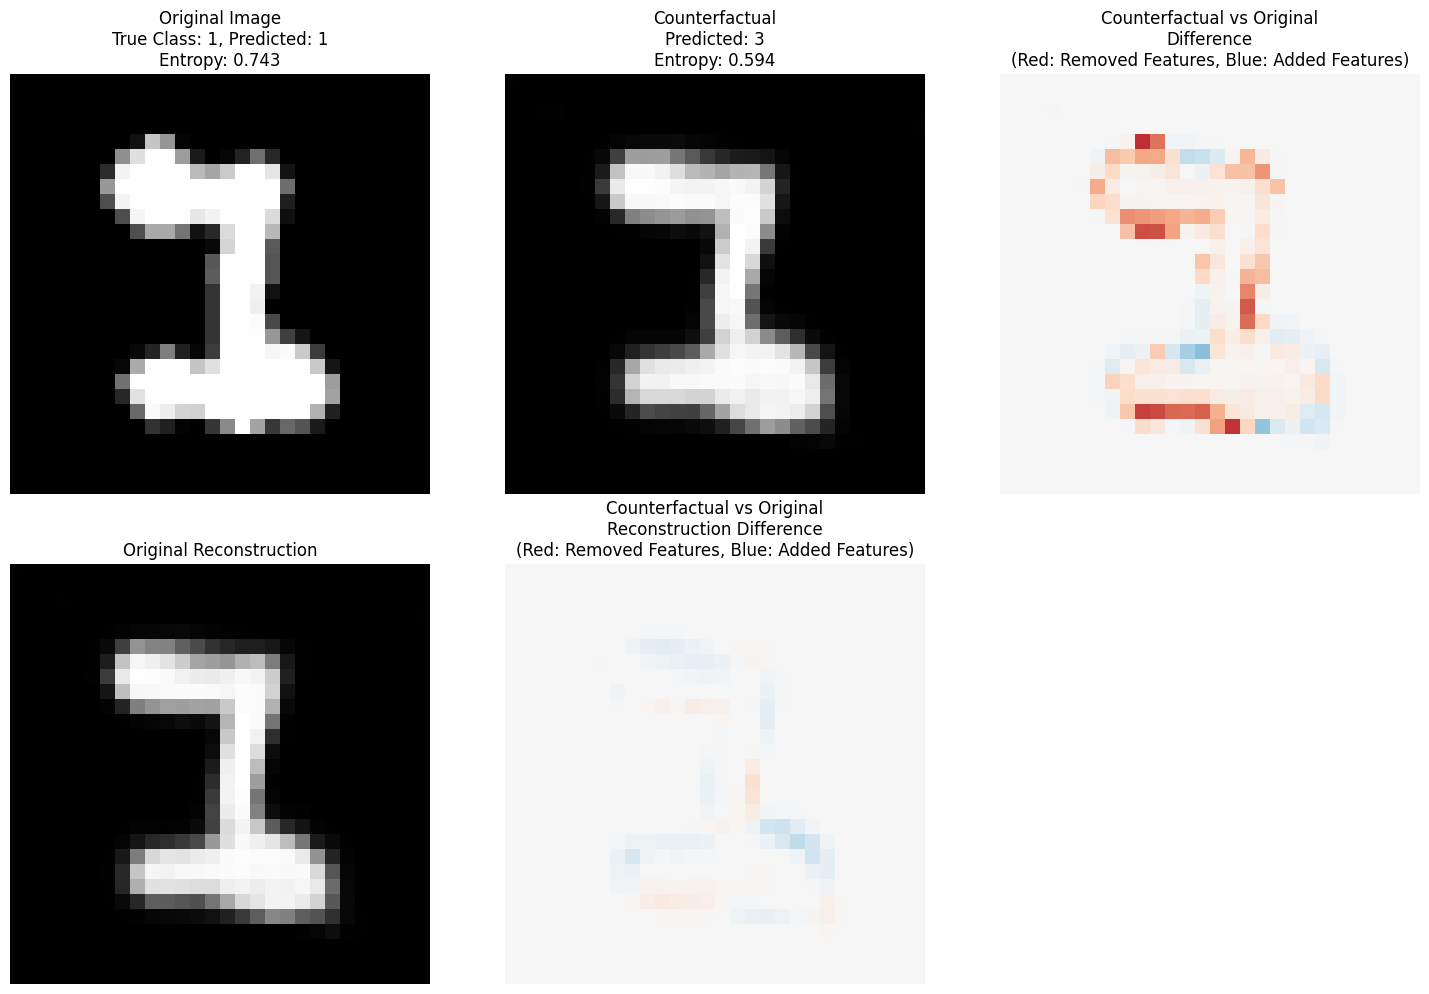


Class probabilities:
Original (True class: 1, Predicted: 1): [0.    0.737 0.021 0.211 0.    0.    0.    0.029 0.    0.   ]
Explained (Predicted: 3): [0.    0.175 0.006 0.8   0.    0.    0.    0.019 0.001 0.   ]


In [40]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[6]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
backbone.eval()
with torch.no_grad():
    z0, _ = backbone(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=backbone.classifier,  # Just use the classifier head
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.05,
    lr=0.1,
    device=cfg.device,
    bayesian=False,  # Non-Bayesian mode
    verbose=True
)

# Optimize to find explanation
z_explained = clue.optimize(steps=200)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = decoder(z0)
    # CLUE reconstruction  
    clue_recon = decoder(z_explained)
    
    # Get predictions from classifier head
    original_logits = backbone.classifier(z0)
    explained_logits = backbone.classifier(z_explained)
    
    # Convert to probabilities
    original_probs = torch.nn.functional.softmax(original_logits, dim=1)
    explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
    
    # Get predictions from full classifier workflow on reconstructions
    _, original_recon_logits = backbone(original_recon)
    _, explained_recon_logits = backbone(clue_recon)
    
    original_recon_probs = torch.nn.functional.softmax(original_recon_logits, dim=1)
    explained_recon_probs = torch.nn.functional.softmax(explained_recon_logits, dim=1)
    
    # Calculate entropies for latent predictions
    original_entropy_latent = -(original_probs * torch.log(original_probs + 1e-10)).sum(dim=1)
    explained_entropy_latent = -(explained_probs * torch.log(explained_probs + 1e-10)).sum(dim=1)
    
    # Calculate entropies for reconstruction predictions
    original_entropy_recon = -(original_recon_probs * torch.log(original_recon_probs + 1e-10)).sum(dim=1)
    explained_entropy_recon = -(explained_recon_probs * torch.log(explained_recon_probs + 1e-10)).sum(dim=1)

    # Get predicted classes
    original_pred = original_recon_probs.argmax(dim=1).item()
    explained_pred = explained_recon_probs.argmax(dim=1).item()

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nTrue Class: {true_label}, Predicted: {original_pred}\nEntropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(233)
diff = clue_recon[0,0].cpu().detach() - uncertain_image[0,0].cpu()
plt.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nDifference\n(Red: Removed Features, Blue: Added Features)')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
recon_diff = clue_recon[0,0].cpu().detach() - original_recon[0,0].cpu().detach()
plt.imshow(recon_diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nReconstruction Difference\n(Red: Removed Features, Blue: Added Features)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities
print("\nClass probabilities:")
print(f"Original (True class: {true_label}, Predicted: {original_pred}):", original_recon_probs.cpu().numpy()[0].round(3))
print(f"Explained (Predicted: {explained_pred}):", explained_recon_probs.cpu().numpy()[0].round(3))


And the BLL VI

Step 00: Loss: 1.3743, Total Entropy: 1.3743, Epistemic Entropy: 0.7764, Aleatoric Entropy: 0.5979, Distance: 0.0000
Step 01: Loss: 1.3021, Total Entropy: 1.2941, Epistemic Entropy: 0.7435, Aleatoric Entropy: 0.5506, Distance: 0.1600
Step 02: Loss: 1.3184, Total Entropy: 1.3054, Epistemic Entropy: 0.7230, Aleatoric Entropy: 0.5824, Distance: 0.2601
Step 03: Loss: 1.3328, Total Entropy: 1.3146, Epistemic Entropy: 0.7082, Aleatoric Entropy: 0.6065, Distance: 0.3635
Step 04: Loss: 1.3504, Total Entropy: 1.3272, Epistemic Entropy: 0.7285, Aleatoric Entropy: 0.5987, Distance: 0.4628
Step 05: Loss: 1.2548, Total Entropy: 1.2268, Epistemic Entropy: 0.6758, Aleatoric Entropy: 0.5510, Distance: 0.5584
Step 06: Loss: 1.3914, Total Entropy: 1.3585, Epistemic Entropy: 0.7465, Aleatoric Entropy: 0.6120, Distance: 0.6572
Step 07: Loss: 1.3755, Total Entropy: 1.3377, Epistemic Entropy: 0.7380, Aleatoric Entropy: 0.5996, Distance: 0.7572
Step 08: Loss: 1.2787, Total Entropy: 1.2359, Epistemic Entropy:

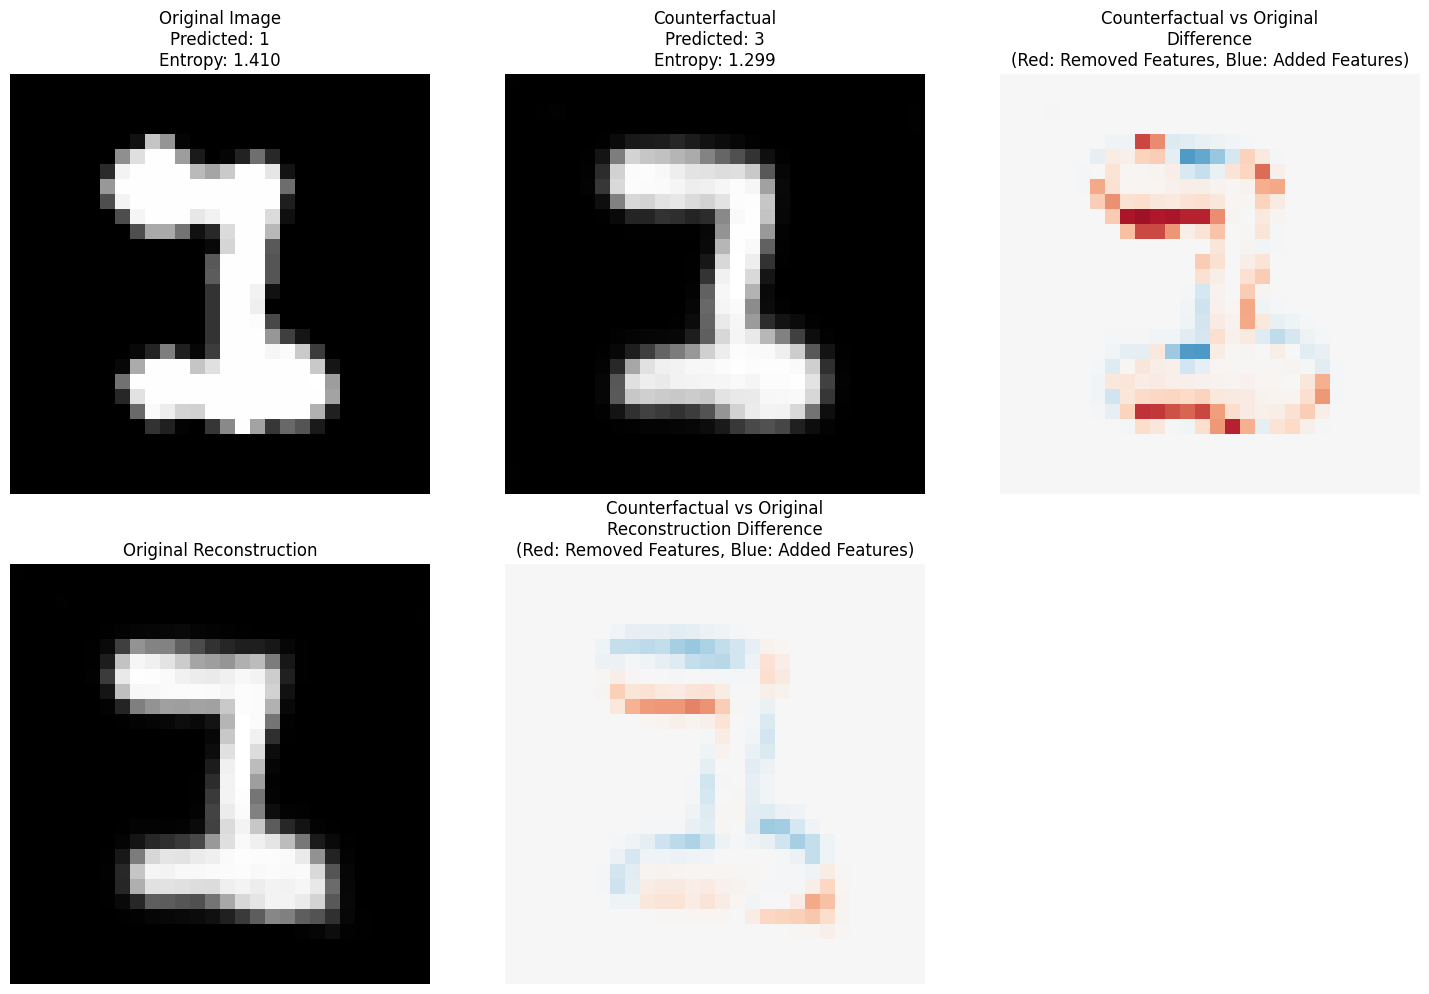

In [43]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[6]
uncertain_image, _ = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
bll.eval()
with torch.no_grad():
    z0 = bll_vi.extract_features(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=bll_vi,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.05,
    lr=0.01,
    device=cfg.device,
    bayesian=True,
    verbose=True
)

# Optimize to find explanation
z_explained = clue.optimize(steps=200)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = decoder(z0)
    # CLUE reconstruction  
    clue_recon = decoder(z_explained)
    
    # Get predictions and uncertainties from latent codes
    original_probs_latent = bll_vi.sample_predict_z(z0)  # [n_ensemble, batch, classes]
    explained_probs_latent = bll_vi.sample_predict_z(z_explained)
    
    # Get predictions from full classifier workflow on reconstructions
    original_probs_recon = bll_vi.sample_predict(original_recon)
    explained_probs_recon = bll_vi.sample_predict(clue_recon)
    
    # Calculate mean probabilities and entropies for latent predictions
    original_mean_probs_latent = original_probs_latent.mean(dim=0)  # [batch, classes]
    explained_mean_probs_latent = explained_probs_latent.mean(dim=0)
    
    original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
    explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)
    
    # Calculate mean probabilities and entropies for reconstruction predictions
    original_mean_probs_recon = original_probs_recon.mean(dim=0)
    explained_mean_probs_recon = explained_probs_recon.mean(dim=0)
    
    original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
    explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)

    # Get predicted classes
    original_pred = original_mean_probs_recon.argmax(dim=1).item()
    explained_pred = explained_mean_probs_recon.argmax(dim=1).item()

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nPredicted: {original_pred}\nEntropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(233)
diff = clue_recon[0,0].cpu().detach() - uncertain_image[0,0].cpu()
plt.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nDifference\n(Red: Removed Features, Blue: Added Features)')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
recon_diff = clue_recon[0,0].cpu().detach() - original_recon[0,0].cpu().detach()
plt.imshow(recon_diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nReconstruction Difference\n(Red: Removed Features, Blue: Added Features)')
plt.axis('off')

plt.tight_layout()
plt.show()


And now the BLL VI with joint training

Step 00: Loss: 1.5358, Total Entropy: 1.5358, Epistemic Entropy: 1.1291, Aleatoric Entropy: 0.4067, Distance: 0.0000
Step 01: Loss: 1.5459, Total Entropy: 1.5379, Epistemic Entropy: 1.1344, Aleatoric Entropy: 0.4035, Distance: 0.1600
Step 02: Loss: 1.5789, Total Entropy: 1.5680, Epistemic Entropy: 1.1727, Aleatoric Entropy: 0.3954, Distance: 0.2171
Step 03: Loss: 1.5103, Total Entropy: 1.4973, Epistemic Entropy: 1.0995, Aleatoric Entropy: 0.3977, Distance: 0.2608
Step 04: Loss: 1.4722, Total Entropy: 1.4566, Epistemic Entropy: 1.0721, Aleatoric Entropy: 0.3844, Distance: 0.3122
Step 05: Loss: 1.5286, Total Entropy: 1.5100, Epistemic Entropy: 1.0837, Aleatoric Entropy: 0.4263, Distance: 0.3711
Step 06: Loss: 1.4936, Total Entropy: 1.4721, Epistemic Entropy: 1.1418, Aleatoric Entropy: 0.3303, Distance: 0.4290
Step 07: Loss: 1.4851, Total Entropy: 1.4612, Epistemic Entropy: 1.0453, Aleatoric Entropy: 0.4159, Distance: 0.4777
Step 08: Loss: 1.6127, Total Entropy: 1.5862, Epistemic Entropy:

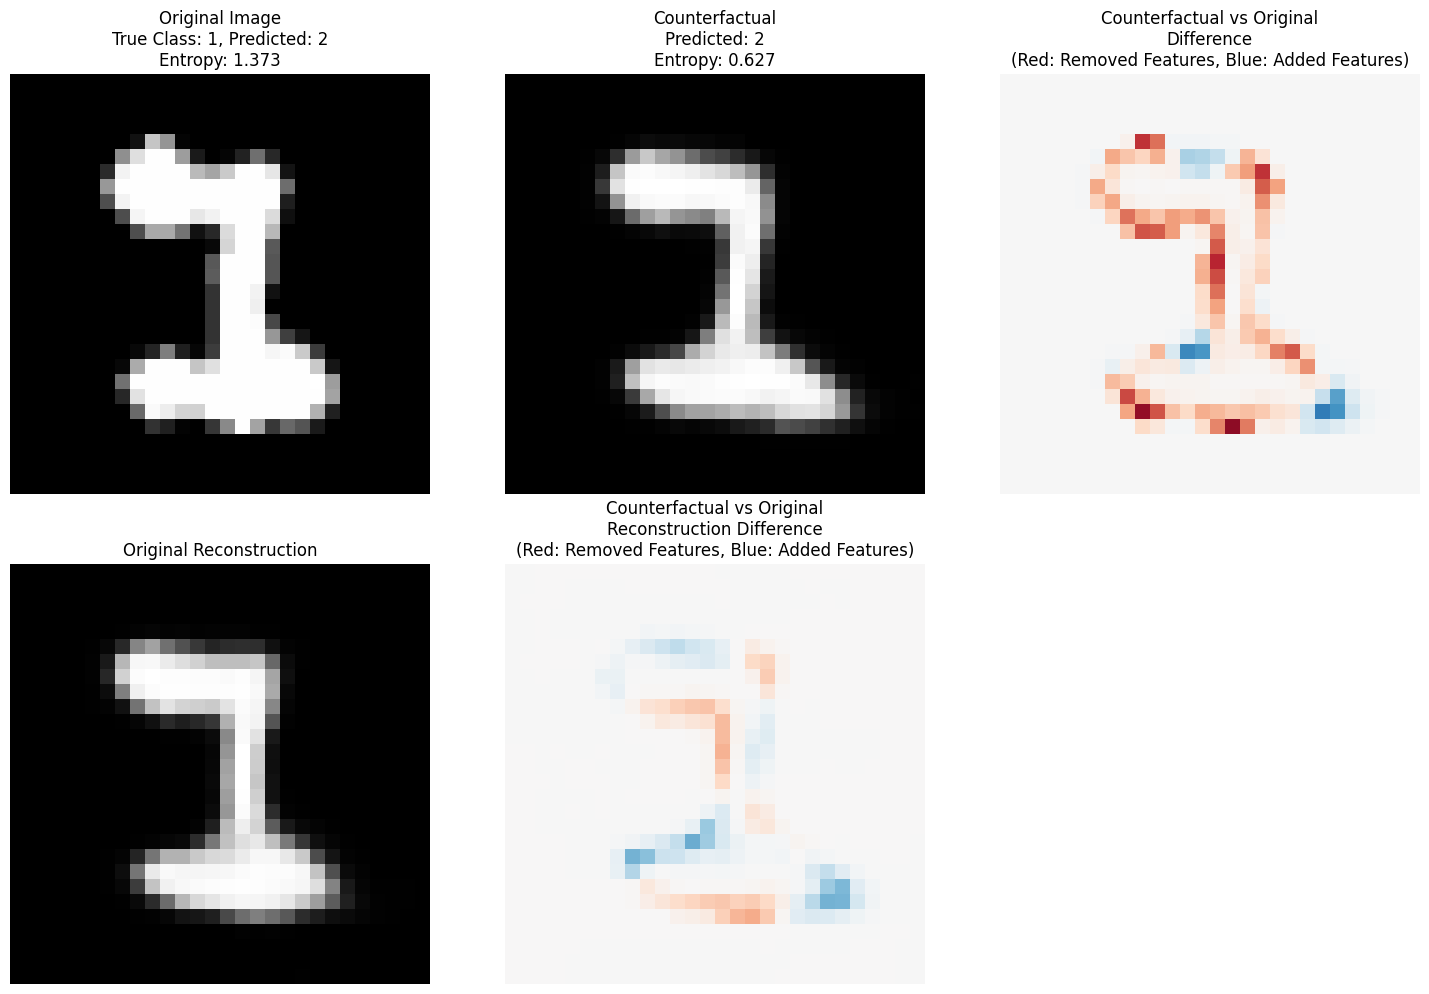


Class probabilities:
Original (True class: 1, Predicted: 2): [0.    0.242 0.326 0.091 0.    0.015 0.    0.324 0.001 0.002]
Explained (Predicted: 2): [0.    0.081 0.829 0.018 0.    0.    0.    0.071 0.    0.   ]


In [45]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[6]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
bll_vi_joint.eval()
with torch.no_grad():
    z0 = bll_vi_joint.extract_features(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=bll_vi_joint,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.05,
    lr=0.01,
    device=cfg.device,
    bayesian=True,
    verbose=True
)

# Optimize to find explanation
z_explained = clue.optimize(steps=200)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = joint_decoder(z0)
    # CLUE reconstruction  
    clue_recon = joint_decoder(z_explained)
    
    # Get predictions and uncertainties from latent codes
    original_probs_latent = bll_vi_joint.sample_predict_z(z0)  # [n_ensemble, batch, classes]
    explained_probs_latent = bll_vi_joint.sample_predict_z(z_explained)
    
    # Get predictions from full classifier workflow on reconstructions
    original_probs_recon = bll_vi_joint.sample_predict(original_recon)
    explained_probs_recon = bll_vi_joint.sample_predict(clue_recon)
    
    # Calculate mean probabilities and entropies for latent predictions
    original_mean_probs_latent = original_probs_latent.mean(dim=0)  # [batch, classes]
    explained_mean_probs_latent = explained_probs_latent.mean(dim=0)
    
    original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
    explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)
    
    # Calculate mean probabilities and entropies for reconstruction predictions
    original_mean_probs_recon = original_probs_recon.mean(dim=0)
    explained_mean_probs_recon = explained_probs_recon.mean(dim=0)
    
    original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
    explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)

    # Get predicted classes
    original_pred = original_mean_probs_recon.argmax(dim=1).item()
    explained_pred = explained_mean_probs_recon.argmax(dim=1).item()
# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nTrue Class: {true_label}, Predicted: {original_pred}\nEntropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(233)
diff = clue_recon[0,0].cpu().detach() - uncertain_image[0,0].cpu()
plt.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nDifference\n(Red: Removed Features, Blue: Added Features)')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
recon_diff = clue_recon[0,0].cpu().detach() - original_recon[0,0].cpu().detach()
plt.imshow(recon_diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nReconstruction Difference\n(Red: Removed Features, Blue: Added Features)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities
print("\nClass probabilities:")
print(f"Original (True class: {true_label}, Predicted: {original_pred}):", original_mean_probs_recon.cpu().numpy()[0].round(3))
print(f"Explained (Predicted: {explained_pred}):", explained_mean_probs_recon.cpu().numpy()[0].round(3))



Below, we plot the t-SNE of the latent space of the test set. We can see that the optimised latent code is close to the original latent code, but not identical.


Distance between original and explained points in t-SNE space: 0.131
Distance between explained and reconstructed points in t-SNE space: 0.018


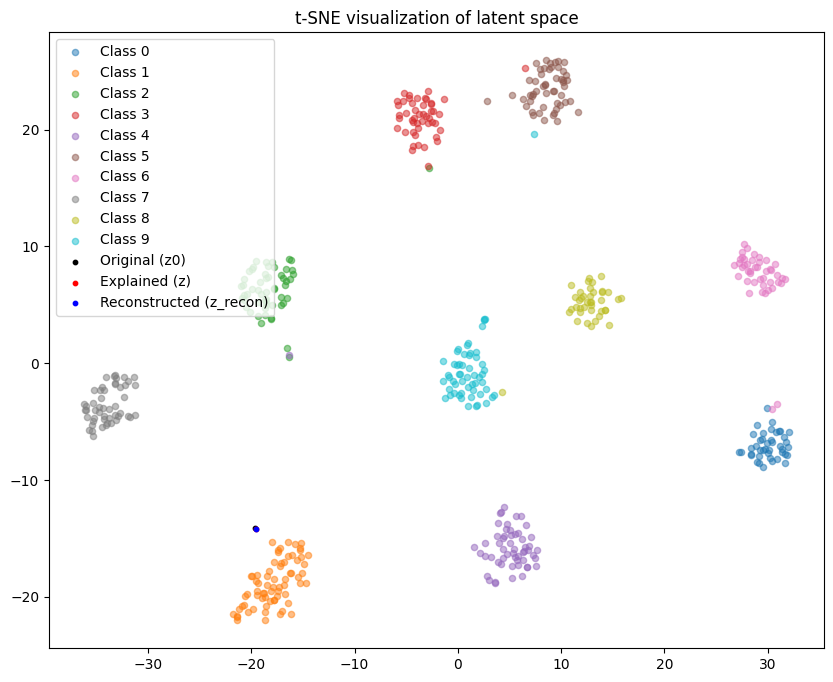

In [61]:
# Get latent codes for 500 training images to create TSNE visualization
latent_codes = []
labels_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        if i >= 500/images.shape[0]:  # Stop after ~500 images
            break
        images = images.to(cfg.device)
        z = bll_vi.extract_features(images)  # Use bll_vi.extract_features instead of backbone
        latent_codes.append(z.cpu())
        labels_list.append(labels)
latent_codes = torch.cat(latent_codes, dim=0)
labels = torch.cat(labels_list, dim=0)

# Get latent code of reconstructed counterfactual
with torch.no_grad():
    z_recon = bll_vi.extract_features(clue_recon)

# Add z0, z_explained and z_recon to the latent codes
all_latents = torch.cat([latent_codes, z0.cpu(), z_explained.cpu(), z_recon.cpu()], dim=0)

# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(all_latents.numpy())

# Plot t-SNE
plt.figure(figsize=(10, 8))

# Create scatter plot for each class
testing_latents_2d = latents_2d[:-3]
for i in range(10):
    mask = labels == i
    plt.scatter(testing_latents_2d[mask, 0], testing_latents_2d[mask, 1], 
               alpha=0.5, label=f'Class {i}', s=20)  # Reduced point size to 20

# Plot original, explained and reconstructed points
plt.scatter(latents_2d[-3, 0], latents_2d[-3, 1], c='black', s=10, label='Original (z0)')
plt.scatter(latents_2d[-2, 0], latents_2d[-2, 1], c='red', s=10, label='Explained (z)')
plt.scatter(latents_2d[-1, 0], latents_2d[-1, 1], c='blue', s=10, label='Reconstructed (z_recon)')

# Calculate and print distances between points in t-SNE space
tsne_distance_orig_exp = np.sqrt(np.sum((latents_2d[-3] - latents_2d[-2])**2))
tsne_distance_exp_recon = np.sqrt(np.sum((latents_2d[-2] - latents_2d[-1])**2))
print(f"\nDistance between original and explained points in t-SNE space: {tsne_distance_orig_exp:.3f}")
print(f"Distance between explained and reconstructed points in t-SNE space: {tsne_distance_exp_recon:.3f}")

plt.title('t-SNE visualization of latent space')
plt.legend()
plt.show()


### Comparing metrics between Bayesian and Deterministic Last Layer

Test on the MCMC BLL

In [47]:
# Get 50 most uncertain images
uncertain_indices = sorted_data_indices[:50]

# Initialize lists to store metrics
latent_entropy_reductions = []
recon_entropy_reductions = []
distances = []

# Process each uncertain image
for idx in uncertain_indices:
    uncertain_image, _ = testset[idx]
    uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)  # Add batch dimension

    # Get latent representation
    bll.eval()
    with torch.no_grad():
        z0 = bll.extract_features(uncertain_image)

    # Initialize CLUE
    clue = new_CLUE.NewCLUE(
        classifier=bll,
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.005,
        lr=0.1,
        device=cfg.device,
        bayesian=True
    )

    # Optimize to find explanation
    z_explained = clue.optimize(steps=200)

    # Calculate distance between original and explained latent codes
    distance = torch.norm(z0 - z_explained).item()
    distances.append(distance)

    # Generate reconstructions using decoder
    with torch.no_grad():
        # Original reconstruction
        original_recon = decoder(z0)
        # CLUE reconstruction  
        clue_recon = decoder(z_explained)
        
        # Get predictions and uncertainties from latent codes
        original_probs_latent = bll.sample_predict_z(z0)
        explained_probs_latent = bll.sample_predict_z(z_explained)
        
        # Get predictions from full classifier workflow on reconstructions
        original_probs_recon = bll.sample_predict(original_recon)
        explained_probs_recon = bll.sample_predict(clue_recon)
        
        # Calculate mean probabilities and entropies for latent predictions
        original_mean_probs_latent = original_probs_latent.mean(dim=0)
        explained_mean_probs_latent = explained_probs_latent.mean(dim=0)
        
        original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
        explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)
        
        # Calculate mean probabilities and entropies for reconstruction predictions
        original_mean_probs_recon = original_probs_recon.mean(dim=0)
        explained_mean_probs_recon = explained_probs_recon.mean(dim=0)
        
        original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
        explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)

        # Calculate entropy reductions
        latent_entropy_reduction = (original_entropy_latent - explained_entropy_latent).item()
        recon_entropy_reduction = (original_entropy_recon - explained_entropy_recon).item()
        
        latent_entropy_reductions.append(latent_entropy_reduction)
        recon_entropy_reductions.append(recon_entropy_reduction)

# Calculate averages
avg_latent_entropy_reduction = np.mean(latent_entropy_reductions)
avg_recon_entropy_reduction = np.mean(recon_entropy_reductions)
avg_distance = np.mean(distances)

print(f"\nResults over {len(uncertain_indices)} most uncertain images:")
print(f"Average latent entropy reduction: {avg_latent_entropy_reduction:.3f}")
print(f"Average reconstruction entropy reduction: {avg_recon_entropy_reduction:.3f}")
print(f"Average distance between original and explained latents: {avg_distance:.3f}")


Step 00: Loss: 1.7058, Total Entropy: 1.7058, Epistemic Entropy: 0.0355, Aleatoric Entropy: 1.6703, Distance: 0.0000
Step 01: Loss: 1.0065, Total Entropy: 0.9985, Epistemic Entropy: 0.0204, Aleatoric Entropy: 0.9782, Distance: 1.6000
Step 02: Loss: 0.2621, Total Entropy: 0.2484, Epistemic Entropy: 0.0034, Aleatoric Entropy: 0.2449, Distance: 2.7443
Step 03: Loss: 0.0590, Total Entropy: 0.0393, Epistemic Entropy: 0.0003, Aleatoric Entropy: 0.0390, Distance: 3.9371
Step 04: Loss: 0.0322, Total Entropy: 0.0073, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0072, Distance: 4.9978
Step 05: Loss: 0.0312, Total Entropy: 0.0017, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0017, Distance: 5.9131
Step 06: Loss: 0.0340, Total Entropy: 0.0005, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0005, Distance: 6.7045
Step 07: Loss: 0.0371, Total Entropy: 0.0002, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0002, Distance: 7.3933
Step 08: Loss: 0.0400, Total Entropy: 0.0001, Epistemic Entropy:

Test on the Deterministic last layer

In [16]:
# Get 50 most uncertain images
uncertain_indices = sorted_data_indices[:50]

# Initialize lists to store metrics
latent_entropy_reductions = []
recon_entropy_reductions = []
distances = []

# Process each uncertain image
for idx in uncertain_indices:
    uncertain_image, _ = testset[idx]
    uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)  # Add batch dimension

    # Get latent representation
    backbone.eval()
    with torch.no_grad():
        z0, _ = backbone(uncertain_image)

    # Initialize CLUE
    clue = new_CLUE.NewCLUE(
        classifier=backbone.classifier,  # Just use the classifier head
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.005,
        lr=0.1,
        device=cfg.device,
        bayesian=False,  # Non-Bayesian mode
        verbose=False
    )

    # Optimize to find explanation
    z_explained = clue.optimize(steps=400)

    # Calculate distance between original and explained latent codes
    distance = torch.norm(z0 - z_explained).item()
    distances.append(distance)

    # Generate reconstructions using decoder
    with torch.no_grad():
        # Original reconstruction
        original_recon = decoder(z0)
        # CLUE reconstruction  
        clue_recon = decoder(z_explained)
        
        # Get predictions from classifier head
        original_logits = backbone.classifier(z0)
        explained_logits = backbone.classifier(z_explained)
        
        # Convert to probabilities
        original_probs = torch.nn.functional.softmax(original_logits, dim=1)
        explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
        
        # Get predictions from full classifier workflow on reconstructions
        _, original_recon_logits = backbone(original_recon)
        _, explained_recon_logits = backbone(clue_recon)
        
        original_recon_probs = torch.nn.functional.softmax(original_recon_logits, dim=1)
        explained_recon_probs = torch.nn.functional.softmax(explained_recon_logits, dim=1)
        
        # Calculate entropies for latent predictions
        original_entropy_latent = -(original_probs * torch.log(original_probs + 1e-10)).sum(dim=1)
        explained_entropy_latent = -(explained_probs * torch.log(explained_probs + 1e-10)).sum(dim=1)
        
        # Calculate entropies for reconstruction predictions
        original_entropy_recon = -(original_recon_probs * torch.log(original_recon_probs + 1e-10)).sum(dim=1)
        explained_entropy_recon = -(explained_recon_probs * torch.log(explained_recon_probs + 1e-10)).sum(dim=1)

        # Calculate entropy reductions
        latent_entropy_reduction = (original_entropy_latent - explained_entropy_latent).item()
        recon_entropy_reduction = (original_entropy_recon - explained_entropy_recon).item()
        
        latent_entropy_reductions.append(latent_entropy_reduction)
        recon_entropy_reductions.append(recon_entropy_reduction)

# Calculate averages
avg_latent_entropy_reduction = np.mean(latent_entropy_reductions)
avg_recon_entropy_reduction = np.mean(recon_entropy_reductions)
avg_distance = np.mean(distances)

print(f"\nResults over {len(uncertain_indices)} most uncertain images:")
print(f"Average latent entropy reduction: {avg_latent_entropy_reduction:.3f}")
print(f"Average reconstruction entropy reduction: {avg_recon_entropy_reduction:.3f}")
print(f"Average distance between original and explained latents: {avg_distance:.3f}")



Results over 50 most uncertain images:
Average latent entropy reduction: 0.775
Average reconstruction entropy reduction: 0.160
Average distance between original and explained latents: 5.906


Test on the VI BLL

In [26]:
# Get 50 most uncertain images
uncertain_indices = sorted_data_indices[:50]

# Initialize lists to store metrics
latent_entropy_reductions = []
recon_entropy_reductions = []
distances = []

# Process each uncertain image
for idx in uncertain_indices:
    uncertain_image, _ = testset[idx]
    uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)  # Add batch dimension

    # Get latent representation
    bll_vi.eval()
    with torch.no_grad():
        z0 = bll_vi.extract_features(uncertain_image)

    # Initialize CLUE
    clue = new_CLUE.NewCLUE(
        classifier=bll_vi,
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.005,
        lr=0.1,
        device=cfg.device,
        bayesian=True, 
        verbose=False
    )

    # Optimize to find explanation
    z_explained = clue.optimize(steps=200)

    # Calculate distance between original and explained latent codes
    distance = torch.norm(z0 - z_explained).item()
    distances.append(distance)

    # Generate reconstructions using decoder
    with torch.no_grad():
        # Original reconstruction
        original_recon = decoder(z0)
        # CLUE reconstruction  
        clue_recon = decoder(z_explained)
        
        # Get predictions and uncertainties from latent codes
        original_probs_latent = bll_vi.sample_predict_z(z0)
        explained_probs_latent = bll_vi.sample_predict_z(z_explained)
        
        # Get predictions from full classifier workflow on reconstructions
        original_probs_recon = bll_vi.sample_predict(original_recon)
        explained_probs_recon = bll_vi.sample_predict(clue_recon)
        
        # Calculate mean probabilities and entropies for latent predictions
        original_mean_probs_latent = original_probs_latent.mean(dim=0)
        explained_mean_probs_latent = explained_probs_latent.mean(dim=0)
        
        original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
        explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)
        
        # Calculate mean probabilities and entropies for reconstruction predictions
        original_mean_probs_recon = original_probs_recon.mean(dim=0)
        explained_mean_probs_recon = explained_probs_recon.mean(dim=0)
        
        original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
        explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)

        # Calculate entropy reductions
        latent_entropy_reduction = (original_entropy_latent - explained_entropy_latent).item()
        recon_entropy_reduction = (original_entropy_recon - explained_entropy_recon).item()
        
        latent_entropy_reductions.append(latent_entropy_reduction)
        recon_entropy_reductions.append(recon_entropy_reduction)

# Calculate averages
avg_latent_entropy_reduction = np.mean(latent_entropy_reductions)
avg_recon_entropy_reduction = np.mean(recon_entropy_reductions)
avg_distance = np.mean(distances)

print(f"\nResults over {len(uncertain_indices)} most uncertain images:")
print(f"Average latent entropy reduction: {avg_latent_entropy_reduction:.3f}")
print(f"Average reconstruction entropy reduction: {avg_recon_entropy_reduction:.3f}")
print(f"Average distance between original and explained latents: {avg_distance:.3f}")



Results over 50 most uncertain images:
Average latent entropy reduction: 1.044
Average reconstruction entropy reduction: 0.311
Average distance between original and explained latents: 9.147


### Visualise the results between all models

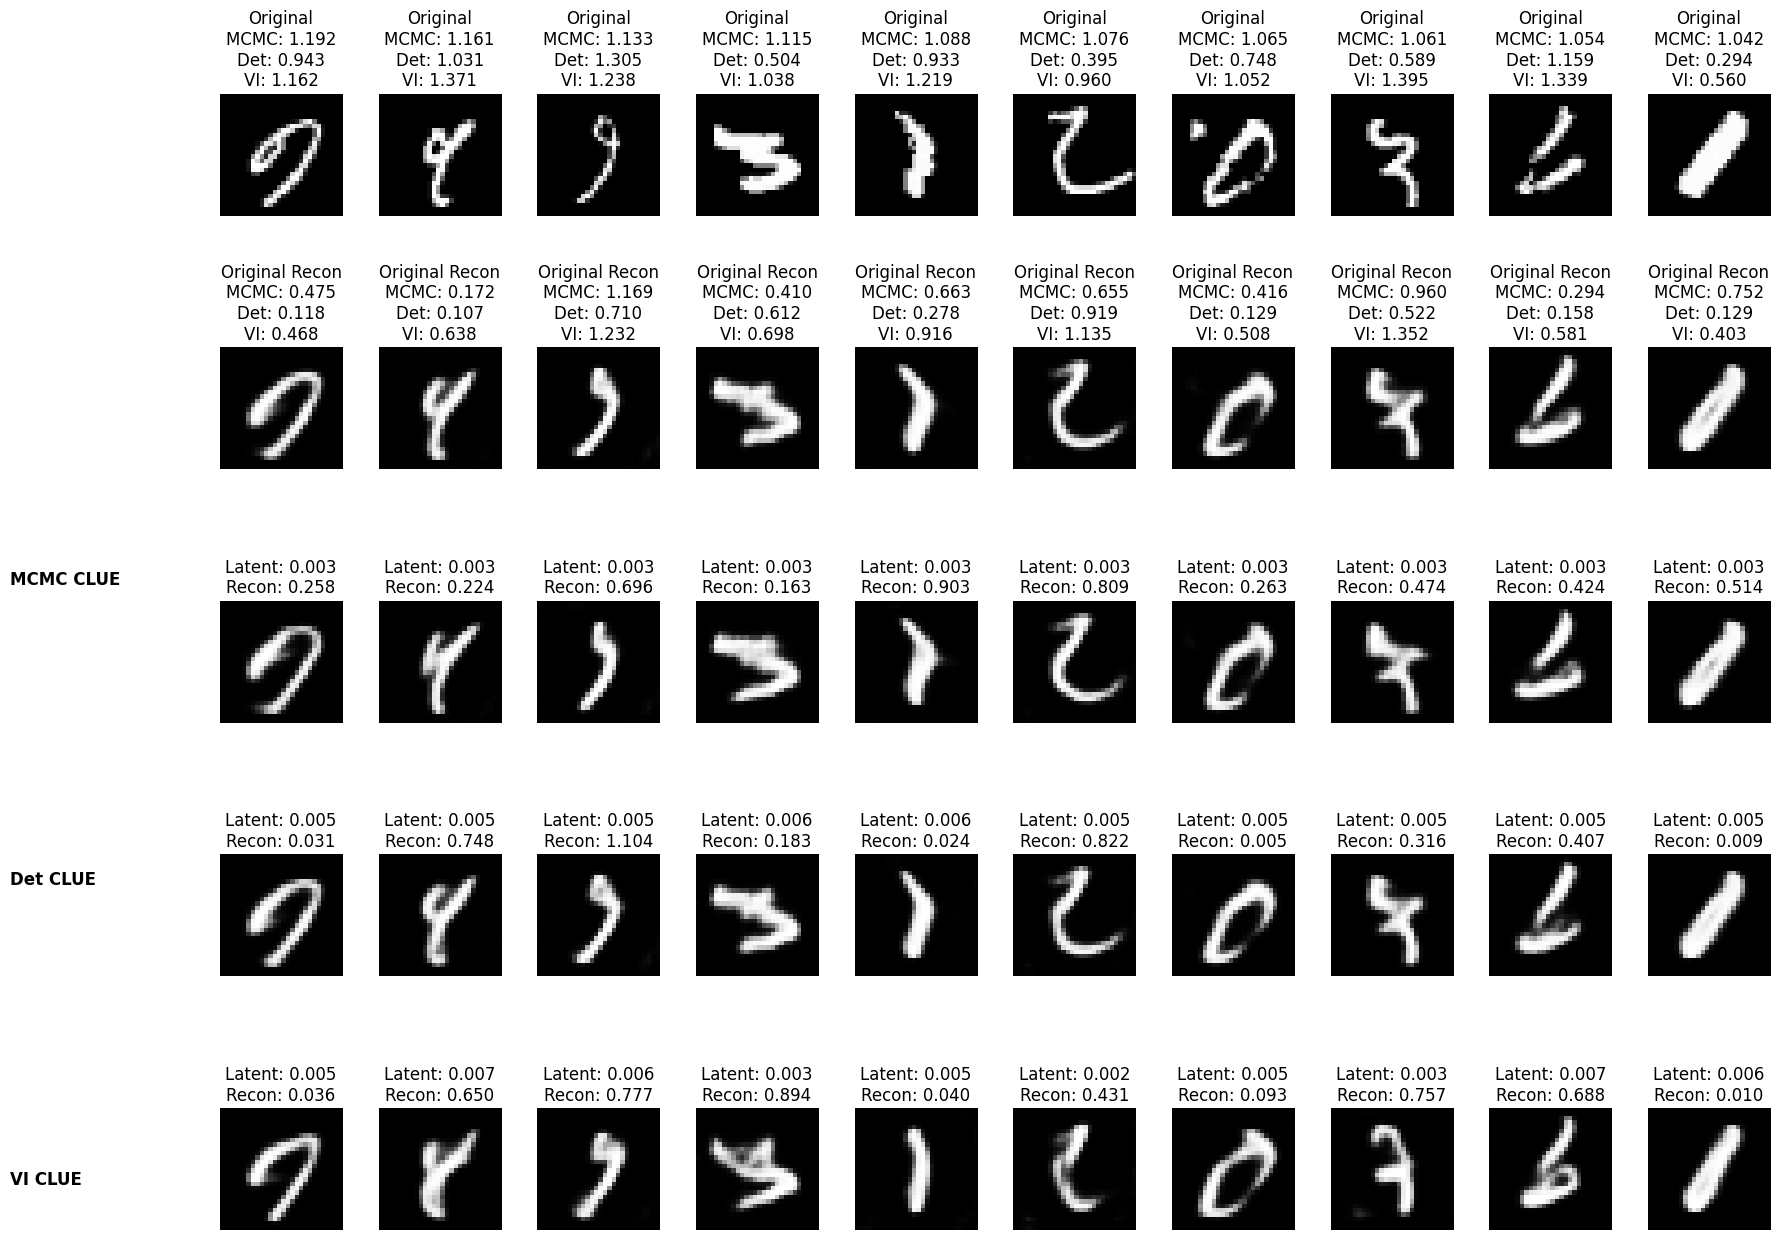

In [62]:
# Get indices of 2 most uncertain images
n_examples = 10
uncertain_indices = sorted_data_indices[9:9+n_examples]

# Set up the plot - now 5 rows
fig, axes = plt.subplots(5, n_examples, figsize=(20, 15))  # Doubled the width from 10 to 20
plt.subplots_adjust(wspace=0.3, hspace=0.8)  # Increased vertical spacing

# Add horizontal y-axis labels with larger font - adjusted y-coordinates
fig.text(0.02, 0.55, 'MCMC CLUE', ha='left', va='center', fontsize=12, fontweight='bold')
fig.text(0.02, 0.35, 'Det CLUE', ha='left', va='center', fontsize=12, fontweight='bold')
fig.text(0.02, 0.15, 'VI CLUE', ha='left', va='center', fontsize=12, fontweight='bold')

for i, idx in enumerate(uncertain_indices):
    # Get image
    uncertain_image, _ = testset[idx]
    uncertain_image = uncertain_image.to(cfg.device).unsqueeze(0)
    
    # Get original latent representations and entropies
    with torch.no_grad():
        # Get original features and entropies
        z0_mcmc = bll.extract_features(uncertain_image)
        mcmc_orig_probs = bll.sample_predict_z(z0_mcmc).mean(0)
        mcmc_orig_entropy = -(mcmc_orig_probs * torch.log(mcmc_orig_probs + 1e-10)).sum(1)
        
        z0_det, _ = backbone(uncertain_image)
        det_orig_logits = backbone.classifier(z0_det)
        det_orig_probs = torch.nn.functional.softmax(det_orig_logits, dim=1)
        det_orig_entropy = -(det_orig_probs * torch.log(det_orig_probs + 1e-10)).sum(1)
        
        z0_vi = bll_vi.extract_features(uncertain_image)
        vi_orig_probs = bll_vi.sample_predict_z(z0_vi).mean(0)
        vi_orig_entropy = -(vi_orig_probs * torch.log(vi_orig_probs + 1e-10)).sum(1)
    
    # Original image with all entropies
    axes[0,i].imshow(uncertain_image.squeeze().cpu(), cmap='gray')
    axes[0,i].axis('off')
    axes[0,i].set_title(f'Original\nMCMC: {mcmc_orig_entropy[0]:.3f}\nDet: {det_orig_entropy[0]:.3f}\nVI: {vi_orig_entropy[0]:.3f}')
    
    # Original reconstruction and its entropies
    with torch.no_grad():
        # Get reconstruction
        recon = decoder(z0_mcmc)  # Can use any of the z0s since they should give similar reconstructions
        
        # Get reconstruction entropies for each model
        mcmc_recon_probs = bll.sample_predict(recon).mean(0)
        mcmc_recon_entropy = -(mcmc_recon_probs * torch.log(mcmc_recon_probs + 1e-10)).sum(1)
        
        _, det_recon_logits = backbone(recon)
        det_recon_probs = torch.nn.functional.softmax(det_recon_logits, dim=1)
        det_recon_entropy = -(det_recon_probs * torch.log(det_recon_probs + 1e-10)).sum(1)
        
        vi_recon_probs = bll_vi.sample_predict(recon).mean(0)
        vi_recon_entropy = -(vi_recon_probs * torch.log(vi_recon_probs + 1e-10)).sum(1)
    
    # Plot original reconstruction
    axes[1,i].imshow(recon[0,0].cpu().detach(), cmap='gray')
    axes[1,i].axis('off')
    axes[1,i].set_title(f'Original Recon\nMCMC: {mcmc_recon_entropy[0]:.3f}\nDet: {det_recon_entropy[0]:.3f}\nVI: {vi_recon_entropy[0]:.3f}')
    
    # Generate counterfactuals
    clue_mcmc = new_CLUE.NewCLUE(
        classifier=bll,
        z0=z0_mcmc,
        uncertainty_weight=1.0,
        distance_weight=0.005,
        lr=0.1,
        device=cfg.device,
        bayesian=True,
        verbose=False
    )
    z_explained_mcmc = clue_mcmc.optimize(steps=200)
    
    clue_det = new_CLUE.NewCLUE(
        classifier=backbone.classifier,
        z0=z0_det,
        uncertainty_weight=1.0,
        distance_weight=0.005,
        lr=0.1,
        device=cfg.device,
        bayesian=False,
        verbose=False
    )
    z_explained_det = clue_det.optimize(steps=200)
    
    clue_vi = new_CLUE.NewCLUE(
        classifier=bll_vi,
        z0=z0_vi,
        uncertainty_weight=1.0,
        distance_weight=0.005,
        lr=0.1,
        device=cfg.device,
        bayesian=True,
        verbose=False
    )
    z_explained_vi = clue_vi.optimize(steps=200)
    
    # Generate counterfactual reconstructions and compute entropies
    with torch.no_grad():
        # MCMC counterfactual
        mcmc_recon = decoder(z_explained_mcmc)
        mcmc_probs = bll.sample_predict_z(z_explained_mcmc).mean(0)
        mcmc_entropy = -(mcmc_probs * torch.log(mcmc_probs + 1e-10)).sum(1)
        mcmc_recon_probs = bll.sample_predict(mcmc_recon).mean(0)
        mcmc_recon_entropy = -(mcmc_recon_probs * torch.log(mcmc_recon_probs + 1e-10)).sum(1)
        
        # Det counterfactual
        det_recon = decoder(z_explained_det)
        det_logits = backbone.classifier(z_explained_det)
        det_probs = torch.nn.functional.softmax(det_logits, dim=1)
        det_entropy = -(det_probs * torch.log(det_probs + 1e-10)).sum(1)
        _, det_recon_logits = backbone(det_recon)
        det_recon_probs = torch.nn.functional.softmax(det_recon_logits, dim=1)
        det_recon_entropy = -(det_recon_probs * torch.log(det_recon_probs + 1e-10)).sum(1)
        
        # VI counterfactual
        vi_recon = decoder(z_explained_vi)
        vi_probs = bll_vi.sample_predict_z(z_explained_vi).mean(0)
        vi_entropy = -(vi_probs * torch.log(vi_probs + 1e-10)).sum(1)
        vi_recon_probs = bll_vi.sample_predict(vi_recon).mean(0)
        vi_recon_entropy = -(vi_recon_probs * torch.log(vi_recon_probs + 1e-10)).sum(1)
    
    # Plot counterfactuals (without model names in titles)
    axes[2,i].imshow(mcmc_recon[0,0].cpu().detach(), cmap='gray')
    axes[2,i].axis('off')
    axes[2,i].set_title(f'Latent: {mcmc_entropy[0]:.3f}\nRecon: {mcmc_recon_entropy[0]:.3f}')
    
    axes[3,i].imshow(det_recon[0,0].cpu().detach(), cmap='gray')
    axes[3,i].axis('off')
    axes[3,i].set_title(f'Latent: {det_entropy[0]:.3f}\nRecon: {det_recon_entropy[0]:.3f}')
    
    axes[4,i].imshow(vi_recon[0,0].cpu().detach(), cmap='gray')
    axes[4,i].axis('off')
    axes[4,i].set_title(f'Latent: {vi_entropy[0]:.3f}\nRecon: {vi_recon_entropy[0]:.3f}')

plt.show()